<a href="https://colab.research.google.com/github/3m4c/3m4c/blob/main/Tesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
import seaborn as sns

In [ ]:
# loading the dataset
df_master = pd.read_csv('/content/wsb_dataset.csv')

# Data pre-processing

In [33]:
df = df_master.copy()

In [34]:
# creating a list of stocks that we need to eliminate from the posts
# we do this to reduce bias: if GME posts are mostly bullish, the model will recognize the word 'GME' as bullish

# there are some stock symbols that are also normal words: we will leave them in the posts
not_symbols = ['DD', 'IS', 'A', 'BUY', 'ARE', 'ALL', 
              'GOOD', 'GAIN', 'WANT', 'HAS', 'KNOW',
              'GO', 'HOLD', 'AM', 'TOO', 'ONE', 'SEE', 'JOB',
              'IT', 'SEND', 'ATH', 'TALK', 'LOW', 'BY', 'SHIP',
              'REAL', 'IRL', 'PLUS', 'NEW', 'USD', 'YOLO', 'MUST',
              'U', 'PAYS', 'CEO', 'OLD', 'YOU', 'FOR', 'MOON', 'TELL',
              'WELL', 'ON', 'NOW', 'EVER', 'UP', 'AT', 'LIFE', 'JUST', 'BOIL',
              'FUND', 'LOAN', 'IMO', 'PT', 'BIG', 'BE', 'OPEN', 'PLAY', 'TA', 'IPO', 
              'FUD', 'BOND', 'CAN', 'FAIL', 'AWAY', 'FOMO', 'HEAR', 'VIEW', 'BEST', 'VERY',
              'MOVE', 'AIR', 'EAT', 'TRUE', 'DEEP', 'DAWN', 'RISE', 'CENT', 'LOVE', 'MIND', 'TEAM',
              'POST', 'COST', 'DATA', 'VOTE', 'STAY', 'NEXT', 'CASH', 'LACK', 'NEAR', 'COOL', 'ONCE', 'MASS',
              'SENT', 'HOPE', 'NEED', 'ELSE', 'PAY', 'APP', 'MAX', 'EPS', 'MID', 'OIL', 'VS', 'OR', 'MF', 'PLAN', 
              'PICK', 'EARN', 'INFO', 'SUM']

symbols = list(df.stock_symbol.unique())
symbols = list(set(symbols) - set(not_symbols))
symbols = sorted(symbols, key= len, reverse = True)

# this passage is needed to properly eliminate substrings from the posts
long_symbols = [symbol for symbol in symbols if len(symbol) > 2]
short_symbols = [ ' {} '.format(symbol) for symbol in symbols if len(symbols) < 3]

In [35]:
# preparing the dataset

# we replace NaN values with an empty string ('')
df.replace(['[deleted]', '[removed]'], ['', ''], inplace = True)
df.fillna('', inplace = True)

# we merge the three predictors (title, body and flair) into one
df['text'] = df.title + ' ' + df.body + ' ' + df.flair
df.drop(columns = ['title', 'body', 'flair'], inplace = True)

# the model is not good at recognizing bearish posts because we lack bearish training data:
# it make more sense for our purpose to just distinguish between bullish and non-bullish posts
df['sentiment'].replace(['controversial', 'bearish', 'neutral'], 'not bullish', inplace = True)

In [36]:
# cleaning text
df.text = df.text.replace('$', '', regex = True)
df.text = df.text.replace('[^\w\s]', '', regex = True)
df.text = df.text.replace(long_symbols, '', regex = True)
df.text = df.text.replace(short_symbols, ' ', regex = True)

In [37]:
# it's better to shorten posts that are too long (usually Due Diligences)
# we do it by removing the central part
def removecentre(row):
  words = row.split()
  if len(words) > 500:
    row = words[:250] + words[-250:]
    row = ' '.join(row)
  return row 

df.text = df.text.apply(removecentre)

In [38]:
'''
#stemming words makes the algorithm worse
import nltk.stem

def stemrow(row):
  stemmer = nltk.stem.SnowballStemmer('english')
  words = row.split()
  new_row = []
  for word in words:
    new_row.append(stemmer.stem(word))
  new_row_str = ' '.join(map(str, new_row))
  return new_row_str

df.text = df.text.apply(stemrow)
'''

"\n#stemming words makes the algorithm worse\nimport nltk.stem\n\ndef stemrow(row):\n  stemmer = nltk.stem.SnowballStemmer('english')\n  words = row.split()\n  new_row = []\n  for word in words:\n    new_row.append(stemmer.stem(word))\n  new_row_str = ' '.join(map(str, new_row))\n  return new_row_str\n\ndf.text = df.text.apply(stemrow)\n"

In [39]:
'''
#what about lemmatizing?
#it doesn't work either
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def lemrow(row):
  lemmatizer = WordNetLemmatizer()
  words = row.split()
  new_row = []
  for word in words:
    new_word = lemmatizer.lemmatize(word, 'v')
    new_row.append(new_word)
  new_row_str = ' '.join(map(str, new_row))
  return new_row_str

df.text = df.text.apply(lambda x: x.lower())
df.text = df.text.apply(lemrow)
'''

"\n#what about lemmatizing?\n#it doesn't work either\nimport nltk\nnltk.download('wordnet')\nfrom nltk.stem import WordNetLemmatizer\n\ndef lemrow(row):\n  lemmatizer = WordNetLemmatizer()\n  words = row.split()\n  new_row = []\n  for word in words:\n    new_word = lemmatizer.lemmatize(word, 'v')\n    new_row.append(new_word)\n  new_row_str = ' '.join(map(str, new_row))\n  return new_row_str\n\ndf.text = df.text.apply(lambda x: x.lower())\ndf.text = df.text.apply(lemrow)\n"

# Supervised learning

## SGDClassifier

In [40]:
# creating a pipeline
# using CountVectorizer to convert text documents to a matrix of token counts,
# with both monograms and bigrams as tokens
# using TfidTransformer to scale down the impact of tokens that occur very frequently
# using the SGDClassifier model to train the data

text_clf = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,2))),
     ('tfidf', TfidfTransformer()), #we could also use TfidfVectorizer and save one passage
     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=0.00001, random_state = 2,
                           max_iter=6, tol=None, n_jobs = -1,
                           early_stopping = True, validation_fraction = .1
                           ))
])

In [41]:
# first we take only the labelled posts
training = df[df['is_train'] == True]
X, y = training['text'], training['sentiment']

In [42]:
# performing (stratified) K-fold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for train_index, test_index in skf.split(X, y):

  X_train = np.array(X.iloc[train_index]).flatten() # reshaping the input data
  X_test = np.array(X.iloc[test_index]).flatten()
  y_train = y.iloc[train_index]
  y_test = y.iloc[test_index]
    
  # fitting the model to the training data
  text_clf.fit(X_train, y_train)

  # predicting the test labels using the trained model on the test features
  predicted = text_clf.predict(X_test)

  # printing the metrics
  print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

     bullish       0.76      0.79      0.77       130
 not bullish       0.76      0.72      0.74       117

    accuracy                           0.76       247
   macro avg       0.76      0.76      0.76       247
weighted avg       0.76      0.76      0.76       247

              precision    recall  f1-score   support

     bullish       0.75      0.80      0.77       130
 not bullish       0.76      0.70      0.73       116

    accuracy                           0.75       246
   macro avg       0.75      0.75      0.75       246
weighted avg       0.75      0.75      0.75       246

              precision    recall  f1-score   support

     bullish       0.75      0.82      0.78       130
 not bullish       0.77      0.69      0.73       116

    accuracy                           0.76       246
   macro avg       0.76      0.75      0.75       246
weighted avg       0.76      0.76      0.75       246

              preci

In [43]:
# final model

# creating train and test
X_train, X_test, y_train, y_test = train_test_split(training['text'], training['sentiment'], test_size = .15, 
                                                    random_state = 3, stratify = training['sentiment'])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

# we use the model to label the other posts in the dataset
df_to_predict = df[df['is_train'] == False]
labels = text_clf.predict(df_to_predict['text'])

# lastly, we recompose the dataset with the labelled posts
df_final = df_master.copy()
df_final.loc[lambda x: df_final['is_train'] == False, 'sentiment'] = labels

# and we change the labels
df_final['sentiment'].replace(['controversial', 'bearish', 'neutral'], 'not bullish', inplace = True)

              precision    recall  f1-score   support

     bullish       0.84      0.81      0.82        98
 not bullish       0.79      0.83      0.81        87

    accuracy                           0.82       185
   macro avg       0.82      0.82      0.82       185
weighted avg       0.82      0.82      0.82       185



# File export

In [ ]:
# exporting the dataset as a csv file
df_final.to_csv('wsb_dataset_2.csv', sep=';')

# Data visualization

In [ ]:
print(df_final['stock_symbol'].value_counts()[:20])

GME     1396
AMC      505
BB       396
A        254
HOLD     228
YOLO     191
YOU      141
IS       133
DD       130
CLOV     118
BUY      102
ARE       92
FOR       90
WISH      88
MOON      83
UWMC      83
CLNE      82
NOK       78
ON        75
ALL       75
Name: stock_symbol, dtype: int64

In [ ]:
stock_list = ['GME', 'AMC', 'CLOV', 'WISH', 'UWMC', 'CLNE', 'NOK']

In [ ]:
df_final['dt'] = pd.to_datetime(df_final['dt'])

In [ ]:
gme = df_final[(df_final['dt'] < '2021-02-03') & (df_final['stock_symbol'] == 'GME')]
gme = gme[['dt', 'sentiment']]
dummies = pd.get_dummies(gme, columns = ['sentiment'])
gme = pd.concat([gme['dt'], dummies.iloc[:, 1:]], axis = 1).set_index('dt')

In [ ]:
print(gme)

                     sentiment_bullish  sentiment_not bullish
dt                                                           
2021-01-29 21:30:24                  1                      0
2021-02-02 22:49:24                  1                      0
2021-01-28 10:40:08                  0                      1
2021-02-01 18:25:01                  1                      0
2021-01-29 03:33:45                  1                      0
...                                ...                    ...
2021-01-05 15:44:03                  0                      1
2021-01-04 19:52:00                  0                      1
2021-01-04 16:11:52                  1                      0
2021-01-04 09:50:17                  1                      0
2021-01-05 14:37:43                  0                      1

[1020 rows x 2 columns]


In [ ]:
df_counts = gme.resample('D').sum()

In [ ]:
df_counts

,sentiment_bullish,sentiment_not bullish
dt,,
2021-01-04,2,2
2021-01-05,3,7
2021-01-06,1,1
2021-01-07,1,1
2021-01-08,0,2
2021-01-09,0,1
2021-01-10,1,0
2021-01-11,5,4
2021-01-12,2,0


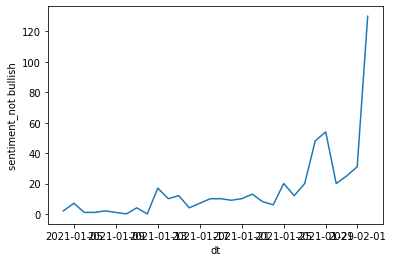

In [ ]:
sns.lineplot(data = df_counts, x = 'dt', y = 'sentiment_not bullish')

# Clustering

## MeanShift

In [ ]:
from sklearn.cluster import MeanShift
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin

class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

text_clf = Pipeline([
     ('tfidf', TfidfVectorizer()),
     ('to_dense', DenseTransformer()),
     ('meanshift', MeanShift(n_jobs = -1)),
])

text_clf.fit(X_train)
print(text_clf[-1].labels_[:1000])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

vect = CountVectorizer(ngram_range=(1, 2))
tfidf = TfidfTransformer()
dense = DenseTransformer()

count_data = vect.fit_transform(X_train)
print(count_data)
tfidf_data = tfidf.fit_transform(count_data)
print(tfidf_data)
dense_data = dense.fit_transform(tfidf_data)
print(dense_data)

In [ ]:
vect = TfidfVectorizer()
dense = DenseTransformer()

tfidf_data = vect.fit_transform(X_train)
print(tfidf_data)
dense_data = dense.fit_transform(tfidf_data)
print(dense_data)

  (0, 3727)	0.07218545105607359
  (0, 5310)	0.07218545105607359
  (0, 5737)	0.043448900551276336
  (0, 5752)	0.043448900551276336
  (0, 1703)	0.04240138900846483
  (0, 7711)	0.02379162448783656
  (0, 6951)	0.025097388580644357
  (0, 6228)	0.04834518261180226
  (0, 4183)	0.02426142042612563
  (0, 2683)	0.036285112394826
  (0, 7230)	0.07218545105607359
  (0, 3531)	0.052152954456319095
  (0, 7716)	0.04707424224693163
  (0, 3672)	0.04929277206567994
  (0, 6988)	0.0543714842750674
  (0, 6509)	0.0543714842750674
  (0, 7703)	0.07218545105607359
  (0, 973)	0.06815425038949763
  (0, 6808)	0.04748010121785229
  (0, 2038)	0.05840268494164336
  (0, 1590)	0.06529406799885847
  (0, 5475)	0.07218545105607359
  (0, 4401)	0.050908561942099764
  (0, 33)	0.041453799554587153
  (0, 6527)	0.04559862619119354
  :	:
  (1045, 7526)	0.1642654224891574
  (1045, 4512)	0.14352855033210418
  (1045, 890)	0.19838528671802586
  (1045, 2759)	0.17463632271507953
  (1045, 7637)	0.37756232209089335
  (1045, 4329)	0.15462

## K-Means

In [ ]:
from sklearn.cluster import MeanShift, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin

class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

text_clf = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,2))),
     ('tfidf', TfidfTransformer()),
     ('km', KMeans(n_clusters = 4, random_state = 2))
     #('to_dense', DenseTransformer()),
     #('meanshift', MeanShift(n_jobs = -1)),
])

text_clf.fit(X_train)
predictions = text_clf.predict(X_train)
for i in range(40):
  print(X_train[i], predictions[i])

## Embedding

In [ ]:
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

In [ ]:
import umap
import umap.plot

In [ ]:
X = df.text
X = np.array(X).flatten()
y = df.sentiment

In [ ]:
vect = TfidfVectorizer()

tfidf_data = vect.fit_transform(X)
embedding = umap.UMAP(n_components = 2, metric = 'cosine').fit(tfidf_data)

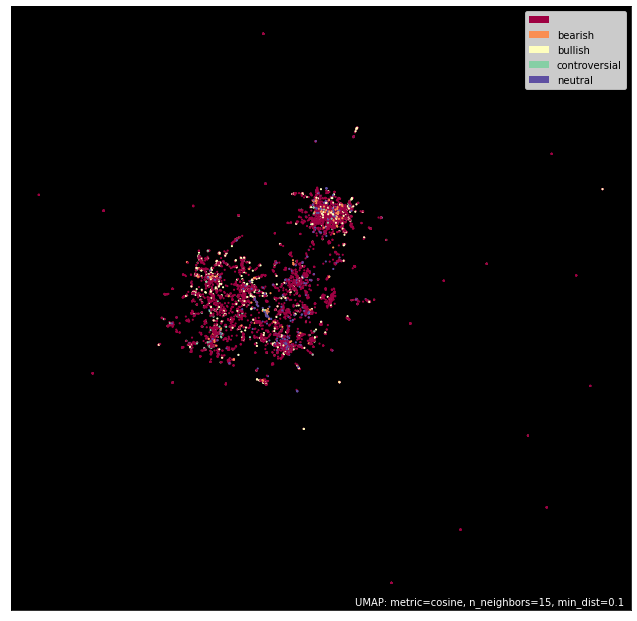

In [ ]:
u = umap.plot.points(embedding, background='black')#, labels = y, background='black')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


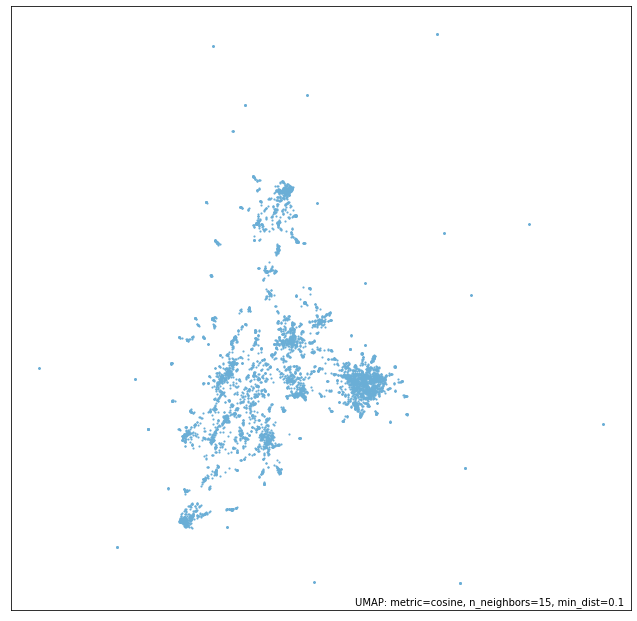

In [ ]:
u = umap.plot.points(embedding)